# Deep Learning Natural Language Processing (NLP) Project - Recurrent Neural Network (RNN) without Long-Short Term Memory in Tensorflow

# Developed a RNN algorithm using a word embedding (vector) layer and mini-batch stochastic descent gradient training to predict text classification [spam or ham (not spam)] for up to a twenty-five (25) word sequence from a SMS dataset.

In [1]:
import os
# import regular expression module for text pattern matching methods (sub)
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

C:\Users\trevo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
epochs = 20
batch_size = 250
max_sequence_length =25

# number of hidden layer nodes
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005

In [3]:
data_dir = 'temp_text_data'
data_file = 'text_data.txt'
text_data_list = []
text_data_target_list = []
text_data_train_list = []

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data_list = text_data.decode().split('\n')
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data_list:
            file_conn.write("{}\n".format(text))
else:
    print('SMS Spam Collection previously downloaded...')
    print()
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data_list.append(row)
            

print('Display Samples of Dataset Formats')
print()            
print('Text data list sample format..last three', text_data_list[(len(text_data_list)-3):len(text_data_list)])
print()
text_data_list = text_data_list[:-1]

print('Text data list first process sample format...last three',\
      text_data_list[(len(text_data_list)-3):len(text_data_list)])

print()

text_data_list = [x.split('\t') for x in text_data_list if len(x)>=1]

print('Text data list second process sample format...first four', text_data_list[0:5])

[text_data_target_list, text_data_train_list]=[list(x) for x in zip(*text_data_list)]
print('Text data target list sample format...first four', text_data_target_list[0:5])
print()
print('Text data train list sample format...first four', text_data_train_list[0:5])        
        
        

SMS Spam Collection previously downloaded...

Display Samples of Dataset Formats

Text data list sample format..last three ["ham\tThe guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free\n", 'ham\tRofl. Its true to its name\n', '\n']

Text data list first process sample format...last three ['ham\tPity, * was in mood for that. So...any other suggestions?\n', "ham\tThe guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free\n", 'ham\tRofl. Its true to its name\n']

Text data list second process sample format...first four [['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'], ['ham', 'Ok lar... Joking wif u oni...\n'], ['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"]

In [4]:
def clean_text(text_string):
    text_string_list = []
    text_string = re.sub(r'([^\s\w] |_| [0-9])+', '', text_string)
    # Need single space with " "
    text_string_list = " ".join(text_string.split())
    # text_string = " ".join(text_string.split())
    text_string_list = text_string_list.lower()
    return (text_string_list)

In [5]:
text_data_train_list = [clean_text(x) for x in text_data_train_list]
print('Cleaned Text data train list sample format...first four', text_data_train_list[0:5]) 
print()
# text_processed_list=[]
vocab_processor = tf.contrib.learn.preprocessing.\
VocabularyProcessor(max_sequence_length, min_frequency=min_word_frequency)

text_processed_list = np.array(list(vocab_processor.fit_transform(text_data_train_list)))
print('Processed Vocab Text', text_processed_list[0:5])

Cleaned Text data train list sample format...first four ['go until jurong pointcrazy.available only in bugis n great world la e buffet..cine there got amore wat...', 'ok lar..joking wif u oni...', "free entry in a wkly comp to win fa cup final tkts1st may005text fa to7121 to receive entry question(std txt rate)t&c's apply8452810075over18's", 'u dun say so early hor..u c already then say...', "nah i don't think he goes to usfhe lives around here though"]

Processed Vocab Text [[ 42 418   0   0 629  71   8   0  77 127 370   0 138   0   0  70  54   0
  133   0   0   0   0   0   0]
 [ 50 345   0 380   6   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 49 439   8   4 704 803   1 220   0   0 545   0   0   0   0   1 340 439
  527 844 120 584 264 570   0]
 [  6 213 130  23 332   0   6 142 150  59 130   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   3  90  88  69 395   1   0   0 211 116 589   0   0   0   0   0   0
    0   0   0   0   0   0 

In [6]:
x_shuffled_list = []
y_shuffled_list = []
text_processed_nparray = np.array(text_processed_list)
# encode target numerical labels one(1) for 'ham'; zero(0) for 'spam'
text_data_encoded_target_list = np.array([1 if x=='ham' else 0 for x in text_data_target_list])
print('Sampled Encoded target numerical labels', text_data_encoded_target_list[0:20])
shuffled_ix_nparray =np.random.permutation(np.arange(len(text_data_target_list)))
x_shuffled_list = text_processed_nparray[shuffled_ix_nparray]
print('Sampled Shuffled Test Data',x_shuffled_list[0:5])
y_shuffled_list = text_data_encoded_target_list[shuffled_ix_nparray]
print('Sampled Shuffled Encoded target numerical labels',y_shuffled_list[0:20])


Sampled Encoded target numerical labels [1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0]
Sampled Shuffled Test Data [[ 50   0   3 240  40 181  27   0  32 176  47 325 215   0 209  42 337  21
    0   4   0   9 380 152  32]
 [  0  21  65   0  41   0   0  11 299   0  10  45  44  21 221 224   0   0
    0   0   0   0   0   0   0]
 [  4   0 130  87 366 169   0  71  84  30 461   9   0   3 563   0   3  90
    0   0   0   0   0   0   0]
 [ 63   1   0  38  21 718  25   4 467  80 256 112   0  35   0   0 196   0
    0  77   0 412 685   0 599]
 [123  50 194  10  70  12   0 396 261   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]
Sampled Shuffled Encoded target numerical labels [1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0]


In [7]:
ix_cutoff = int(len(y_shuffled_list)*0.80)
x_train_list = []
x_test_list = []
y_train_list = []
y_test_list = []
x_train_list, x_test_list = x_shuffled_list[:ix_cutoff], x_shuffled_list[ix_cutoff:]
y_train_list, y_test_list = y_shuffled_list[:ix_cutoff], y_shuffled_list[ix_cutoff:]

vocab_size = len(vocab_processor.vocabulary_)
print('Vocabulary Size: {}'.format(vocab_size))
print('80 - 20 Train Test Split: {} - {}'.format(len(y_train_list),len(y_test_list)))

Vocabulary Size: 863
80 - 20 Train Test Split: 4459 - 1115


In [8]:
tf.reset_default_graph()
dropout_keep_prob = tf.placeholder(tf.float32)
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [9]:
# tf.reset_default_graph()
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [10]:
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [11]:
weight = tf.Variable(tf.truncated_normal([rnn_size,2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_output, logits=logits_out)
loss = tf.reduce_mean(losses)

In [12]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out,1),\
                                           tf.cast(y_output,tf.int64)),\
                                 tf.float32))
# () syntax required to avoid "missing fetches" error
sess=tf.Session()
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

C:\Users\trevo\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(0,epochs):
    shuffled_ix_nparray = np.random.permutation(np.arange(len(x_train_list)))
    x_train_list = x_train_list[shuffled_ix_nparray]
    y_train_list = y_train_list[shuffled_ix_nparray]
    num_batches = int(len(x_train_list)/batch_size)+1
    for i in range(0,num_batches):
        min_ix = i*batch_size
        max_ix = np.min([len(x_train_list), ((i+1)*batch_size)])
        x_train_batch_list = x_train_list[min_ix:max_ix]
        y_train_batch_list = y_train_list[min_ix:max_ix]
        
        train_dict =\
        {x_data:x_train_batch_list,\
         y_output: y_train_batch_list, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss_list.append(temp_train_loss)
    train_accuracy_list.append(temp_train_acc)
    test_dict =\
        {x_data:x_test_list,\
         y_output: y_test_list, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss_list.append(temp_test_loss)
    test_accuracy_list.append(temp_test_acc)
    print('Epoch: {}, Train Loss {:2f}, Train Accuracy {:2f}; Test Loss: {:2f}, Test Accuracy {:2f}'.\
          format((epoch+1), temp_train_loss, temp_train_acc, temp_test_loss, temp_test_acc))

   

Epoch: 1, Train Loss 0.683852, Train Accuracy 0.559809; Test Loss: 0.686509, Test Accuracy 0.838565
Epoch: 2, Train Loss 0.675359, Train Accuracy 0.665072; Test Loss: 0.676406, Test Accuracy 0.847534
Epoch: 3, Train Loss 0.662633, Train Accuracy 0.674641; Test Loss: 0.659259, Test Accuracy 0.852018
Epoch: 4, Train Loss 0.642647, Train Accuracy 0.746412; Test Loss: 0.636441, Test Accuracy 0.855605
Epoch: 5, Train Loss 0.632002, Train Accuracy 0.746412; Test Loss: 0.611365, Test Accuracy 0.858296
Epoch: 6, Train Loss 0.594601, Train Accuracy 0.851675; Test Loss: 0.585727, Test Accuracy 0.859193
Epoch: 7, Train Loss 0.582036, Train Accuracy 0.827751; Test Loss: 0.562773, Test Accuracy 0.862780
Epoch: 8, Train Loss 0.552792, Train Accuracy 0.866029; Test Loss: 0.541147, Test Accuracy 0.866368
Epoch: 9, Train Loss 0.578763, Train Accuracy 0.789474; Test Loss: 0.522175, Test Accuracy 0.872646
Epoch: 10, Train Loss 0.540129, Train Accuracy 0.846890; Test Loss: 0.506422, Test Accuracy 0.873543

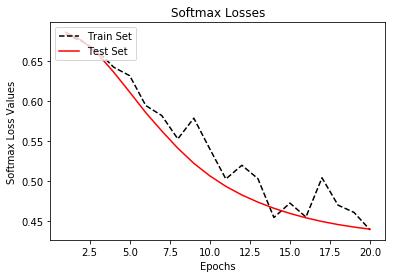

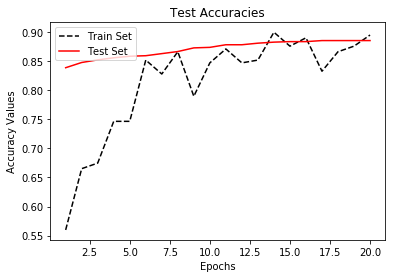

In [14]:
epoch_seq_nparray = np.arange(1, (epochs+1))
plt.plot(epoch_seq_nparray, train_loss_list, 'k--', label = 'Train Set')
plt.plot(epoch_seq_nparray, test_loss_list, 'r-', label = 'Test Set')
plt.title('Softmax Losses')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss Values')
plt.legend(loc='upper left')
plt.show()
plt.plot(epoch_seq_nparray, train_accuracy_list, 'k--', label = 'Train Set')
plt.plot(epoch_seq_nparray, test_accuracy_list, 'r-', label = 'Test Set')
plt.title('Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Values')
plt.legend(loc='upper left')
plt.show()